In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ds_sa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ds_sa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('financial_sentiment_data.csv', encoding='Latin')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
df.dtypes

Sentence     object
Sentiment    object
dtype: object

In [4]:
df['Sentiment'] = df['Sentiment'].astype('category')
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [5]:
df.dtypes

Sentence       object
Sentiment    category
dtype: object

In [6]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [7]:
df[df.duplicated()]

,Sentence,Sentiment
1825,Proha Plc ( Euronext :7327 ) announced today (...,neutral
1859,SSH Communications Security Corporation is hea...,neutral
2672,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
3272,The company serves customers in various indust...,neutral
3986,The issuer is solely responsible for the conte...,neutral
5342,The report profiles 614 companies including ma...,neutral


In [8]:
df.drop_duplicates(inplace=True)
print(f'Number of rows after dropping duplicates: {len(df)}')

Number of rows after dropping duplicates: 5836


In [9]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64

In [10]:
#perform label encoding for the sentiment column
label_encoder = LabelEncoder()
df['Sentiment_label_encode'] = label_encoder.fit_transform(df['Sentiment'])
df

,Sentence,Sentiment,Sentiment_label_encode
0,The GeoSolutions technology will leverage Bene...,positive,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,0
2,"For the last quarter of 2010 , Componenta 's n...",positive,2
3,According to the Finnish-Russian Chamber of Co...,neutral,1
4,The Swedish buyout firm has sold its remaining...,neutral,1
...,...,...,...
5837,RISING costs have forced packaging producer Hu...,negative,0
5838,Nordic Walking was first used as a summer trai...,neutral,1
5839,"According shipping company Viking Line , the E...",neutral,1
5840,"In the building and home improvement trade , s...",neutral,1


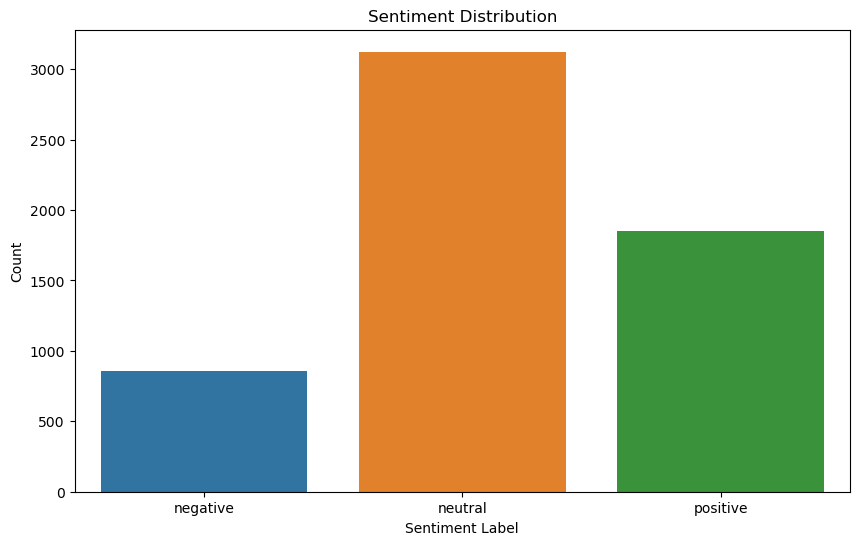

In [11]:
sentiment_counts = df['Sentiment'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [12]:
#Clean the text
import string
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+"," ",text)
    text = re.sub('[‘’“”…]', '', text)
    return text

clean = lambda x: clean_text(x)

df["Sentence"] = df["Sentence"].apply(clean_text) # Clean The Text
df.head()

,Sentence,Sentiment,Sentiment_label_encode
0,the geosolutions technology will leverage bene...,positive,2
1,esi on lows down to bk a real possibility,negative,0
2,for the last quarter of componenta s net sal...,positive,2
3,according to the finnishrussian chamber of com...,neutral,1
4,the swedish buyout firm has sold its remaining...,neutral,1


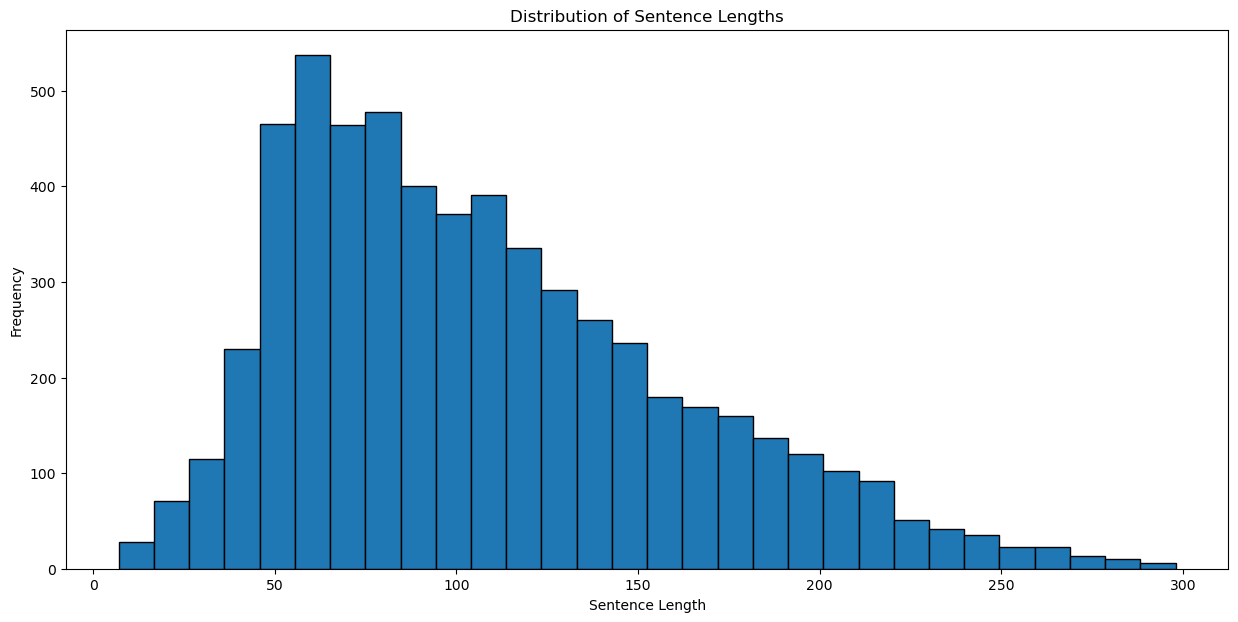

In [13]:
plt.figure(figsize=(15, 7))
df['Sentence_length'] = df['Sentence'].apply(len)
plt.hist(df['Sentence_length'], bins=30, edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
#Frequency before removing stopwords
frequency = pd.Series(' '.join(df['Sentence']).split()).value_counts()
frequency

the           6092
of            3325
in            3133
to            2785
and           2511
              ... 
timetables       1
merges           1
rcp              1
yr               1
yahoos           1
Name: count, Length: 10517, dtype: int64

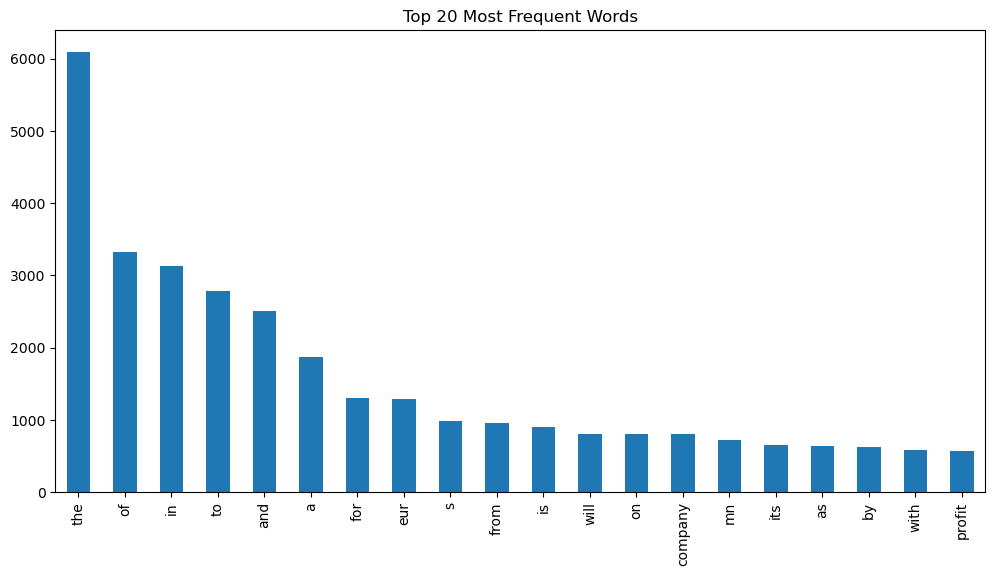

In [15]:
# Visualization of Frequency of words before removing stopwords
plt.figure(figsize=(12, 6))
frequency.head(20).plot(kind='bar')
plt.title('Top 20 Most Frequent Words')
plt.show()

In [16]:
#Removing Stopwords
stop_words = stopwords.words('english')
df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

In [17]:
df.head()

,Sentence,Sentiment,Sentiment_label_encode,Sentence_length
0,geosolutions technology leverage benefon gps s...,positive,2,214
1,esi lows bk real possibility,negative,0,43
2,last quarter componenta net sales doubled peri...,positive,2,165
3,according finnishrussian chamber commerce majo...,neutral,1,125
4,swedish buyout firm sold remaining percent sta...,neutral,1,129


In [18]:
#Frequency after removing stopwords
frequency_stop_words = pd.Series(' '.join(df['Sentence']).split()).value_counts()
frequency_stop_words

eur        1284
company     807
mn          729
profit      568
sales       560
           ... 
merges        1
rcp           1
yr            1
dax           1
yahoos        1
Name: count, Length: 10393, dtype: int64

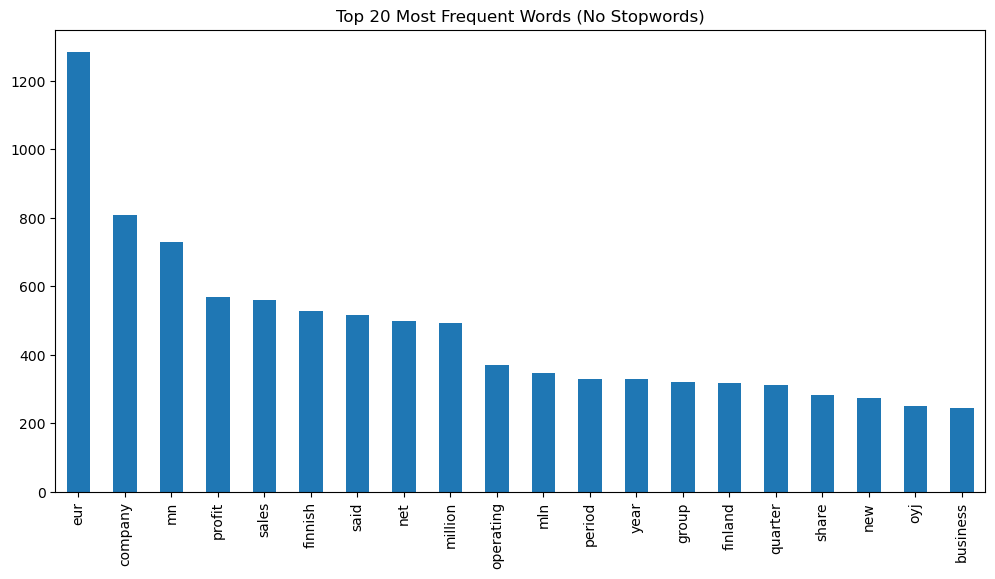

In [19]:
# Visualization of Frequency after removing stopwords
plt.figure(figsize=(12, 6))
frequency_stop_words.head(20).plot(kind='bar')
plt.title('Top 20 Most Frequent Words (No Stopwords)')
plt.show()

In [20]:
#tokenization
df['tokenized_text'] = df['Sentence'].apply(word_tokenize)
df

,Sentence,Sentiment,Sentiment_label_encode,Sentence_length,tokenized_text
0,geosolutions technology leverage benefon gps s...,positive,2,214,"[geosolutions, technology, leverage, benefon, ..."
1,esi lows bk real possibility,negative,0,43,"[esi, lows, bk, real, possibility]"
2,last quarter componenta net sales doubled peri...,positive,2,165,"[last, quarter, componenta, net, sales, double..."
3,according finnishrussian chamber commerce majo...,neutral,1,125,"[according, finnishrussian, chamber, commerce,..."
4,swedish buyout firm sold remaining percent sta...,neutral,1,129,"[swedish, buyout, firm, sold, remaining, perce..."
...,...,...,...,...,...
5837,rising costs forced packaging producer huhtama...,negative,0,104,"[rising, costs, forced, packaging, producer, h..."
5838,nordic walking first used summer training meth...,neutral,1,81,"[nordic, walking, first, used, summer, trainin..."
5839,according shipping company viking line eu deci...,neutral,1,97,"[according, shipping, company, viking, line, e..."
5840,building home improvement trade sales decrease...,neutral,1,76,"[building, home, improvement, trade, sales, de..."


In [21]:
# Lemmatization
df['lemmatized_text'] = df['Sentence'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))
df

,Sentence,Sentiment,Sentiment_label_encode,Sentence_length,tokenized_text,lemmatized_text
0,geosolutions technology leverage benefon gps s...,positive,2,214,"[geosolutions, technology, leverage, benefon, ...",geosolutions technology leverage benefon gps s...
1,esi lows bk real possibility,negative,0,43,"[esi, lows, bk, real, possibility]",esi low bk real possibility
2,last quarter componenta net sales doubled peri...,positive,2,165,"[last, quarter, componenta, net, sales, double...",last quarter componenta net sale doubled perio...
3,according finnishrussian chamber commerce majo...,neutral,1,125,"[according, finnishrussian, chamber, commerce,...",according finnishrussian chamber commerce majo...
4,swedish buyout firm sold remaining percent sta...,neutral,1,129,"[swedish, buyout, firm, sold, remaining, perce...",swedish buyout firm sold remaining percent sta...
...,...,...,...,...,...,...
5837,rising costs forced packaging producer huhtama...,negative,0,104,"[rising, costs, forced, packaging, producer, h...",rising cost forced packaging producer huhtamak...
5838,nordic walking first used summer training meth...,neutral,1,81,"[nordic, walking, first, used, summer, trainin...",nordic walking first used summer training meth...
5839,according shipping company viking line eu deci...,neutral,1,97,"[according, shipping, company, viking, line, e...",according shipping company viking line eu deci...
5840,building home improvement trade sales decrease...,neutral,1,76,"[building, home, improvement, trade, sales, de...",building home improvement trade sale decreased...


In [22]:
#Frequency using CountVectorizer
count_vectorizer = CountVectorizer()
count_vectorizer.fit(df['Sentence'])
count_vectorized = count_vectorizer.transform(df['Sentence'])
word_freq_countvec = pd.DataFrame(count_vectorized.sum(axis=0), columns=count_vectorizer.get_feature_names_out())

In [23]:
word_freq_countvec

,aa,aal,aaland,aalto,aaltonen,aapl,aaron,aava,aazhang,ab,...,zoltan,zone,zoo,zs,zsl,zte,zu,zurich,â¼,ã³
0,1,1,2,1,1,87,1,1,1,39,...,2,11,1,3,1,1,1,1,8,9


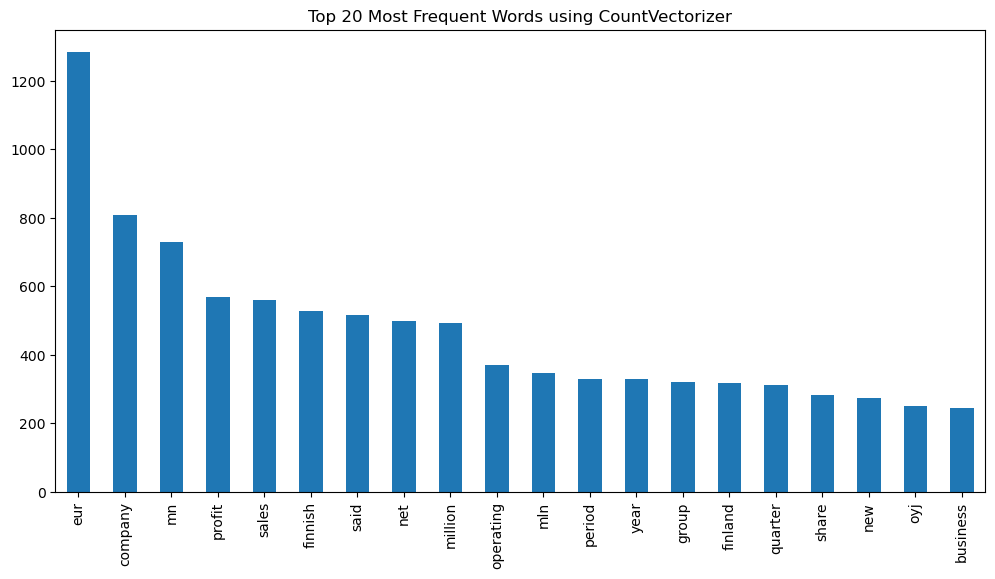

In [24]:
# Frequency using CountVectorizer
plt.figure(figsize=(12, 6))
word_freq_countvec.T.sum(axis=1).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 Most Frequent Words using CountVectorizer')
plt.show()

In [25]:
#Frequency using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df['Sentence'])
tfidf_vectorized = tfidf_vectorizer.transform(df['Sentence'])
word_freq_tfidfvec = pd.DataFrame(tfidf_vectorized.sum(axis=0), columns=tfidf_vectorizer.get_feature_names_out())

In [26]:
word_freq_tfidfvec

,aa,aal,aaland,aalto,aaltonen,aapl,aaron,aava,aazhang,ab,...,zoltan,zone,zoo,zs,zsl,zte,zu,zurich,â¼,ã³
0,0.355752,0.343267,0.624697,0.286204,0.378449,23.961834,0.307078,0.264333,0.35688,9.674508,...,0.458447,3.526888,0.244255,1.442804,0.503951,0.305782,0.209862,0.406451,1.307318,1.523714


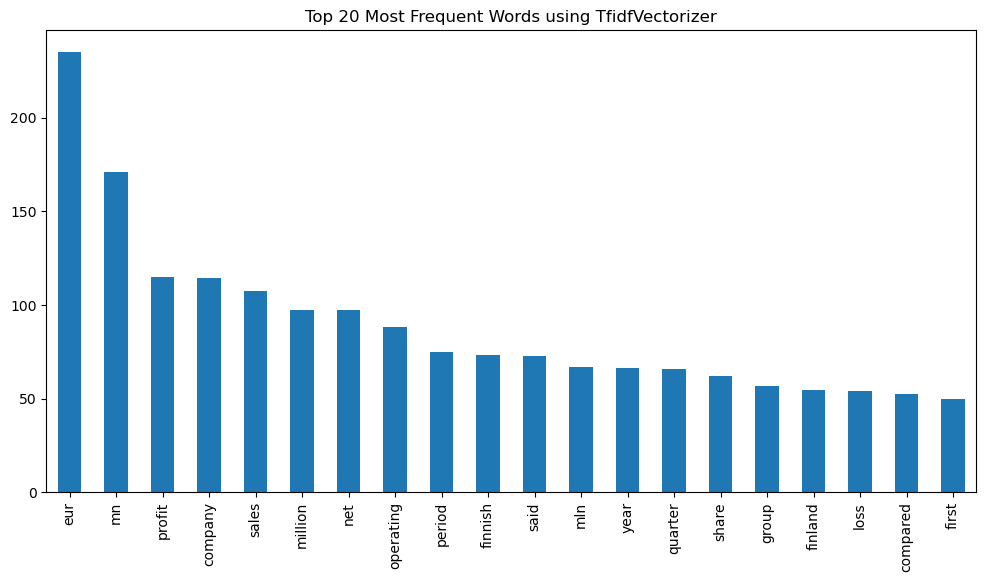

In [27]:
# Frequency using TfidfVectorizer
plt.figure(figsize=(12, 6))
word_freq_tfidfvec.T.sum(axis=1).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 Most Frequent Words using TfidfVectorizer')
plt.show()

In [28]:
# Bigram Visualization
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
bigram_vectorizer.fit(df['Sentence'])
bigram_vectorized = bigram_vectorizer.transform(df['Sentence'])
bigram_freq = pd.DataFrame(bigram_vectorized.sum(axis=0), columns=bigram_vectorizer.get_feature_names_out())

In [29]:
bigram_freq

,aa fb,aal pm,aaland islands,aalto university,aaltonen finland,aapl aapl,aapl action,aapl afternoon,aapl apple,aapl apr,...,zoo poland,zs pharma,zsl looking,zte corp,zu beeinflussen,zurich insurance,â¼ million,â¼ per,ã³ pakistan,ã³ â¼
0,1,1,2,1,1,2,1,1,1,1,...,1,3,1,1,1,1,4,4,1,8


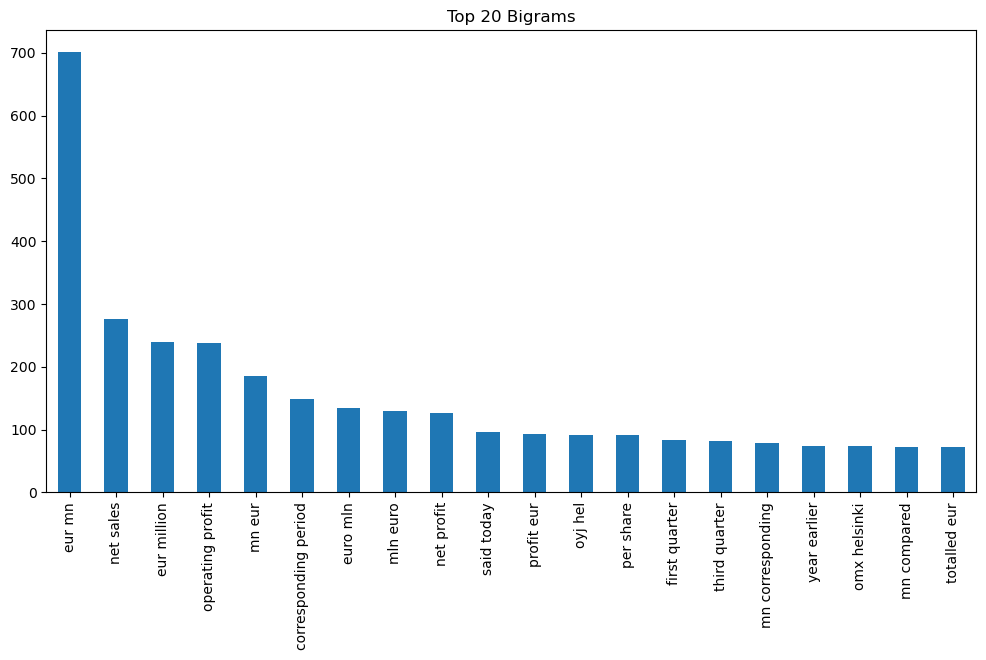

In [30]:
plt.figure(figsize=(12, 6))
bigram_freq.T.sum(axis=1).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 Bigrams')
plt.show()

In [31]:
# Trigram Visualization
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit(df['Sentence'])
trigram_vectorized = trigram_vectorizer.transform(df['Sentence'])
trigram_freq = pd.DataFrame(trigram_vectorized.sum(axis=0), columns=trigram_vectorizer.get_feature_names_out())

In [32]:
trigram_freq

,aal pm london,aalto university universities,aaltonen finland developed,aapl aapl finally,aapl aapl gundlach,aapl action close,aapl afternoon selloff,aapl apple axp,aapl apr calls,aapl aug calls,...,zone still breaking,zone village strelny,zs pharma billion,zsl looking weak,zurich insurance considering,â¼ million ã³,â¼ per share,ã³ pakistan malaysia,ã³ â¼ million,ã³ â¼ per
0,1,1,1,1,1,1,1,1,1,1,...,1,1,3,1,1,4,4,1,4,4


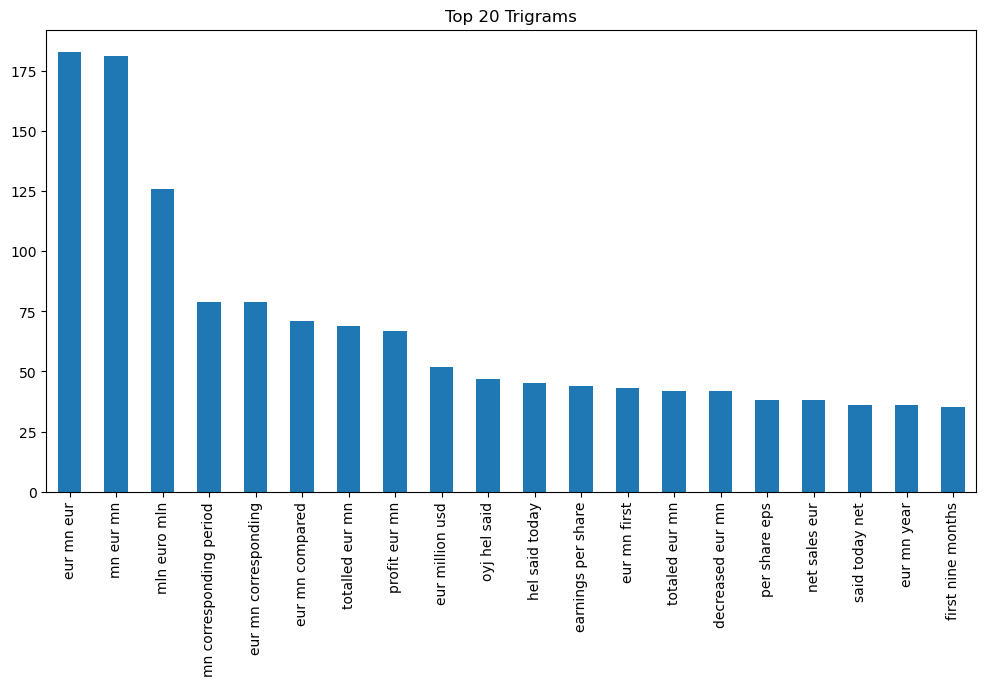

In [33]:
plt.figure(figsize=(12, 6))
trigram_freq.T.sum(axis=1).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 Trigrams')
plt.show()

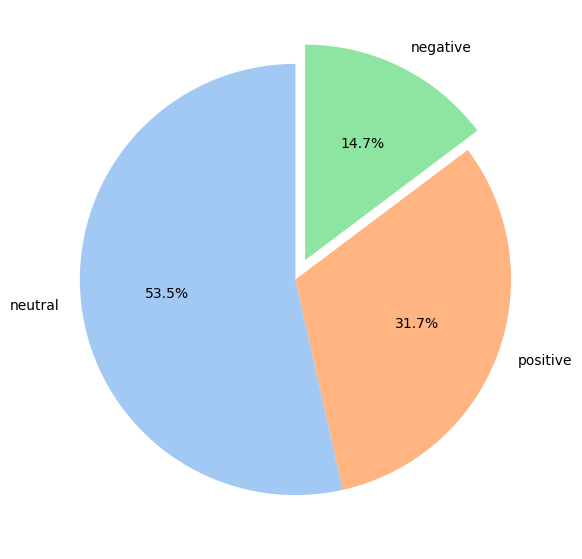

In [34]:
#Visualize Sentiment using pie-chart
# Assuming 'sentiment' is the column with sentiment labels
sentiment_counts = df['Sentiment'].value_counts()
explode=[0, 0, 0.1]

plt.figure(figsize=(15, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', explode=explode, startangle=90, colors=sns.color_palette('pastel'))
plt.show()

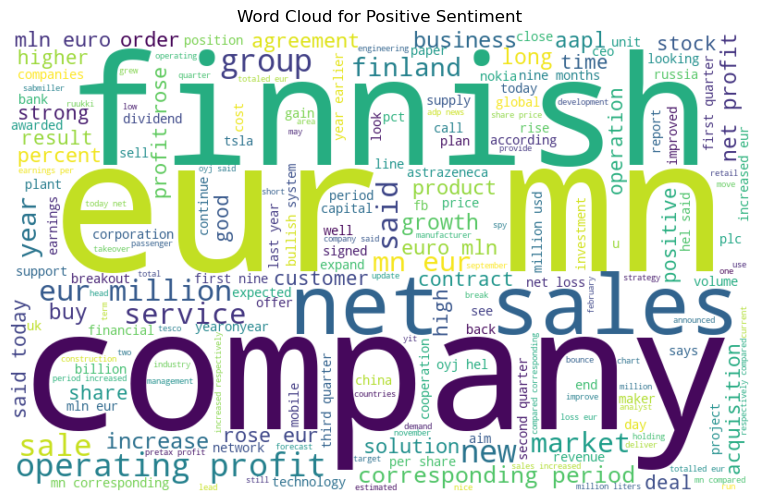

In [35]:
# wordcloud for positive sentiment
positive_text = ' '.join(df[df['Sentiment'] == 'positive']['Sentence'])

# Generate a wordcloud for positive sentiment
wordcloud_positive = WordCloud(width=800, height=500, background_color='white').generate(positive_text)

# Display the generated wordcloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

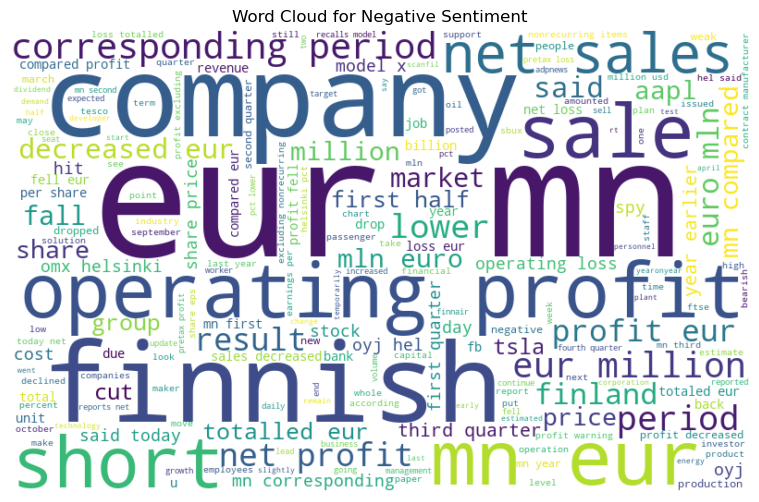

In [36]:
# wordcloud for negative sentiment
negative_text = ' '.join(df[df['Sentiment'] == 'negative']['Sentence'])

# Generate a wordcloud for negative sentiment
wordcloud_negative = WordCloud(width=800, height=500, background_color='white').generate(negative_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

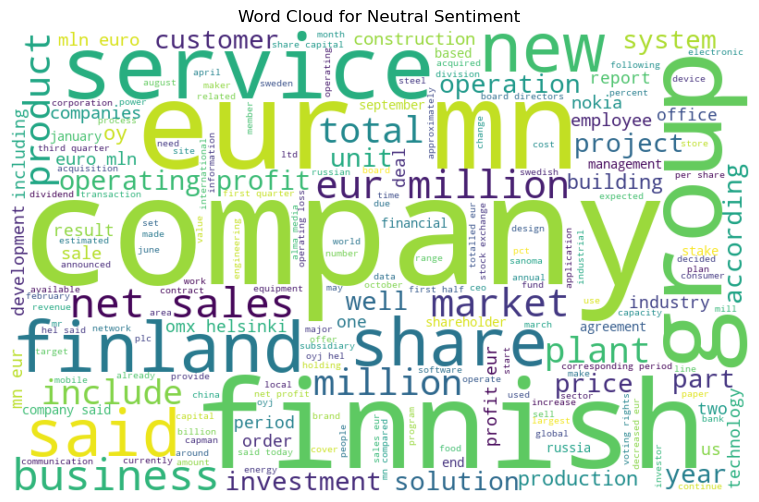

In [37]:
# wordcloud for neutral sentiment
neutral_text = ' '.join(df[df['Sentiment'] == 'neutral']['Sentence'])

# Generate a wordcloud for neutral sentiment
wordcloud_neutral = WordCloud(width=800, height=500, background_color='white').generate(neutral_text)

# Display the generated wordcloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment')
plt.show()

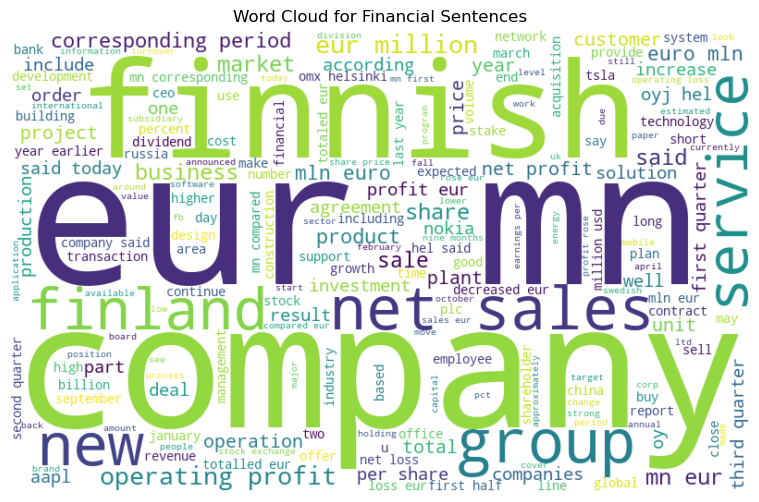

In [38]:
# wordcloud for sentence
sentence = ' '.join(df['Sentence'])

# Generate wordcloud
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(sentence)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Financial Sentences')
plt.show()

In [39]:
analyzer = SentimentIntensityAnalyzer()

In [40]:
# Apply sentiment analysis to the dataset
df['vader_scores'] = df['Sentence'].apply(lambda x: analyzer.polarity_scores(x))

In [41]:
df

,Sentence,Sentiment,Sentiment_label_encode,Sentence_length,tokenized_text,lemmatized_text,vader_scores
0,geosolutions technology leverage benefon gps s...,positive,2,214,"[geosolutions, technology, leverage, benefon, ...",geosolutions technology leverage benefon gps s...,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp..."
1,esi lows bk real possibility,negative,0,43,"[esi, lows, bk, real, possibility]",esi low bk real possibility,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou..."
2,last quarter componenta net sales doubled peri...,positive,2,165,"[last, quarter, componenta, net, sales, double...",last quarter componenta net sale doubled perio...,"{'neg': 0.126, 'neu': 0.714, 'pos': 0.159, 'co..."
3,according finnishrussian chamber commerce majo...,neutral,1,125,"[according, finnishrussian, chamber, commerce,...",according finnishrussian chamber commerce majo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,swedish buyout firm sold remaining percent sta...,neutral,1,129,"[swedish, buyout, firm, sold, remaining, perce...",swedish buyout firm sold remaining percent sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...,...,...,...,...
5837,rising costs forced packaging producer huhtama...,negative,0,104,"[rising, costs, forced, packaging, producer, h...",rising cost forced packaging producer huhtamak...,"{'neg': 0.328, 'neu': 0.672, 'pos': 0.0, 'comp..."
5838,nordic walking first used summer training meth...,neutral,1,81,"[nordic, walking, first, used, summer, trainin...",nordic walking first used summer training meth...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5839,according shipping company viking line eu deci...,neutral,1,97,"[according, shipping, company, viking, line, e...",according shipping company viking line eu deci...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp..."
5840,building home improvement trade sales decrease...,neutral,1,76,"[building, home, improvement, trade, sales, de...",building home improvement trade sale decreased...,"{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound..."


In [42]:
# Extract the compound score
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'] if isinstance(x, dict) else x)

In [43]:
df

,Sentence,Sentiment,Sentiment_label_encode,Sentence_length,tokenized_text,lemmatized_text,vader_scores,vader_compound
0,geosolutions technology leverage benefon gps s...,positive,2,214,"[geosolutions, technology, leverage, benefon, ...",geosolutions technology leverage benefon gps s...,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...",0.5423
1,esi lows bk real possibility,negative,0,43,"[esi, lows, bk, real, possibility]",esi low bk real possibility,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou...",-0.2023
2,last quarter componenta net sales doubled peri...,positive,2,165,"[last, quarter, componenta, net, sales, double...",last quarter componenta net sale doubled perio...,"{'neg': 0.126, 'neu': 0.714, 'pos': 0.159, 'co...",0.1531
3,according finnishrussian chamber commerce majo...,neutral,1,125,"[according, finnishrussian, chamber, commerce,...",according finnishrussian chamber commerce majo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,swedish buyout firm sold remaining percent sta...,neutral,1,129,"[swedish, buyout, firm, sold, remaining, perce...",swedish buyout firm sold remaining percent sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...,...,...,...,...
5837,rising costs forced packaging producer huhtama...,negative,0,104,"[rising, costs, forced, packaging, producer, h...",rising cost forced packaging producer huhtamak...,"{'neg': 0.328, 'neu': 0.672, 'pos': 0.0, 'comp...",-0.5267
5838,nordic walking first used summer training meth...,neutral,1,81,"[nordic, walking, first, used, summer, trainin...",nordic walking first used summer training meth...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
5839,according shipping company viking line eu deci...,neutral,1,97,"[according, shipping, company, viking, line, e...",according shipping company viking line eu deci...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.2023
5840,building home improvement trade sales decrease...,neutral,1,76,"[building, home, improvement, trade, sales, de...",building home improvement trade sale decreased...,"{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...",0.4588


In [44]:
# Categorize sentiment based on the compound score
df['vader_sentiment'] = df['vader_compound'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

In [45]:
df

,Sentence,Sentiment,Sentiment_label_encode,Sentence_length,tokenized_text,lemmatized_text,vader_scores,vader_compound,vader_sentiment
0,geosolutions technology leverage benefon gps s...,positive,2,214,"[geosolutions, technology, leverage, benefon, ...",geosolutions technology leverage benefon gps s...,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...",0.5423,positive
1,esi lows bk real possibility,negative,0,43,"[esi, lows, bk, real, possibility]",esi low bk real possibility,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou...",-0.2023,negative
2,last quarter componenta net sales doubled peri...,positive,2,165,"[last, quarter, componenta, net, sales, double...",last quarter componenta net sale doubled perio...,"{'neg': 0.126, 'neu': 0.714, 'pos': 0.159, 'co...",0.1531,positive
3,according finnishrussian chamber commerce majo...,neutral,1,125,"[according, finnishrussian, chamber, commerce,...",according finnishrussian chamber commerce majo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
4,swedish buyout firm sold remaining percent sta...,neutral,1,129,"[swedish, buyout, firm, sold, remaining, perce...",swedish buyout firm sold remaining percent sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
...,...,...,...,...,...,...,...,...,...
5837,rising costs forced packaging producer huhtama...,negative,0,104,"[rising, costs, forced, packaging, producer, h...",rising cost forced packaging producer huhtamak...,"{'neg': 0.328, 'neu': 0.672, 'pos': 0.0, 'comp...",-0.5267,negative
5838,nordic walking first used summer training meth...,neutral,1,81,"[nordic, walking, first, used, summer, trainin...",nordic walking first used summer training meth...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
5839,according shipping company viking line eu deci...,neutral,1,97,"[according, shipping, company, viking, line, e...",according shipping company viking line eu deci...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.2023,positive
5840,building home improvement trade sales decrease...,neutral,1,76,"[building, home, improvement, trade, sales, de...",building home improvement trade sale decreased...,"{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...",0.4588,positive


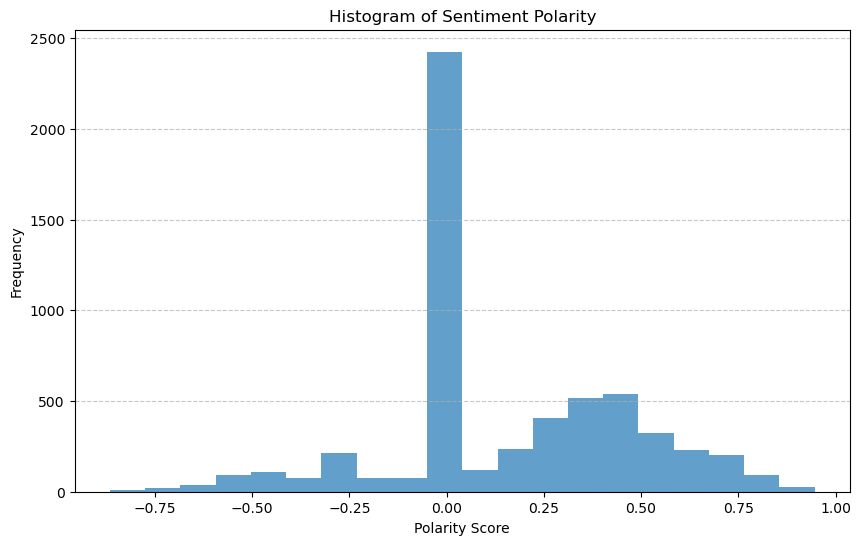

In [46]:
# Assuming 'polarity' is the column with sentiment polarity scores
plt.figure(figsize=(10, 6))
plt.hist(df['vader_compound'], bins=20, alpha=0.7)
plt.title('Histogram of Sentiment Polarity')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

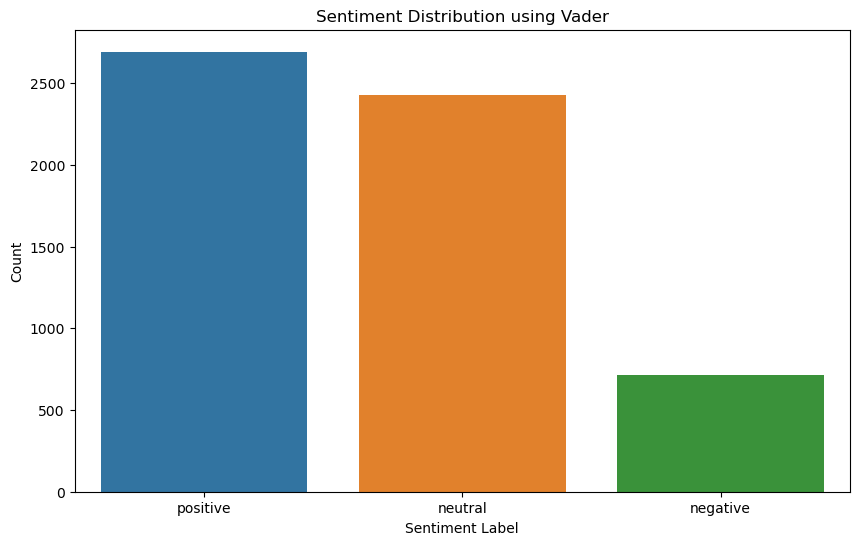

In [47]:
sentiment_counts1 = df['vader_sentiment'].value_counts()

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts1.index, y=sentiment_counts1.values)
plt.title('Sentiment Distribution using Vader')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [48]:
sentiment_counts1

vader_sentiment
positive    2693
neutral     2426
negative     717
Name: count, dtype: int64

In [49]:
#perform label encoding on vader sentiment
label_encoder1 = LabelEncoder()
df['vader_sentiment_label_encode'] = label_encoder1.fit_transform(df['vader_sentiment'])
df

,Sentence,Sentiment,Sentiment_label_encode,Sentence_length,tokenized_text,lemmatized_text,vader_scores,vader_compound,vader_sentiment,vader_sentiment_label_encode
0,geosolutions technology leverage benefon gps s...,positive,2,214,"[geosolutions, technology, leverage, benefon, ...",geosolutions technology leverage benefon gps s...,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...",0.5423,positive,2
1,esi lows bk real possibility,negative,0,43,"[esi, lows, bk, real, possibility]",esi low bk real possibility,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou...",-0.2023,negative,0
2,last quarter componenta net sales doubled peri...,positive,2,165,"[last, quarter, componenta, net, sales, double...",last quarter componenta net sale doubled perio...,"{'neg': 0.126, 'neu': 0.714, 'pos': 0.159, 'co...",0.1531,positive,2
3,according finnishrussian chamber commerce majo...,neutral,1,125,"[according, finnishrussian, chamber, commerce,...",according finnishrussian chamber commerce majo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,1
4,swedish buyout firm sold remaining percent sta...,neutral,1,129,"[swedish, buyout, firm, sold, remaining, perce...",swedish buyout firm sold remaining percent sta...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,1
...,...,...,...,...,...,...,...,...,...,...
5837,rising costs forced packaging producer huhtama...,negative,0,104,"[rising, costs, forced, packaging, producer, h...",rising cost forced packaging producer huhtamak...,"{'neg': 0.328, 'neu': 0.672, 'pos': 0.0, 'comp...",-0.5267,negative,0
5838,nordic walking first used summer training meth...,neutral,1,81,"[nordic, walking, first, used, summer, trainin...",nordic walking first used summer training meth...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,1
5839,according shipping company viking line eu deci...,neutral,1,97,"[according, shipping, company, viking, line, e...",according shipping company viking line eu deci...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.2023,positive,2
5840,building home improvement trade sales decrease...,neutral,1,76,"[building, home, improvement, trade, sales, de...",building home improvement trade sale decreased...,"{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...",0.4588,positive,2


## Model Building

In [50]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['vader_sentiment_label_encode'], test_size=0.2, random_state=42)

In [53]:
#Initialize the count vectorizer for bag of wods
vectorizer = CountVectorizer()

### Bag of Words

In [54]:
# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(X_train)

In [55]:
# Transform the testing data
X_test_bow = vectorizer.transform(X_test)

### Logistic Regression 

In [56]:
# Initialize the Logistic Regression
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_logreg = classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Accuracy: {accuracy_logreg:.2%}')

# Generate and print the classification report
classification_report_logreg = classification_report(y_test, y_pred_logreg, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
print('\nConfusion Matrix:\n', conf_matrix_logreg)

Accuracy: 84.50%
Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.56      0.69       133
     neutral       0.79      0.94      0.86       513
    positive       0.91      0.82      0.86       522

    accuracy                           0.85      1168
   macro avg       0.86      0.78      0.80      1168
weighted avg       0.85      0.85      0.84      1168


Confusion Matrix:
 [[ 75  42  16]
 [  1 484  28]
 [  9  85 428]]


Cross-validation Scores: [0.81477516 0.83404711 0.85867238 0.8392283  0.81457663]
Mean CV Accuracy: 0.8322599154026408


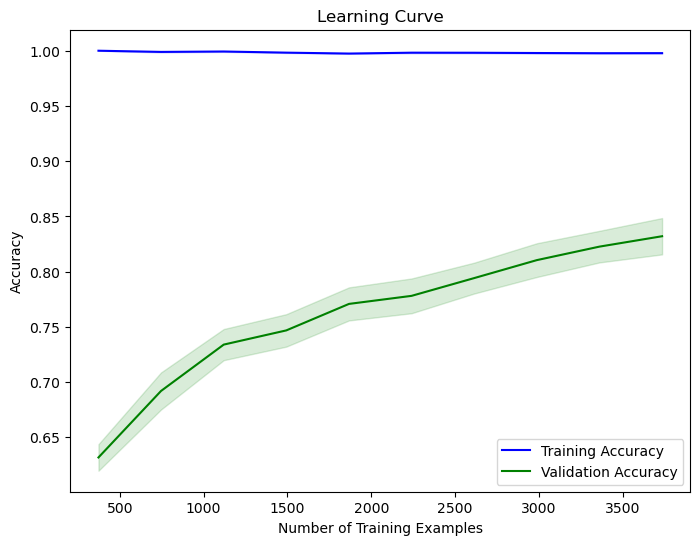

Regularized Logistic Regression Accuracy: 85.45%


In [57]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(classifier, X_train_bow, y_train, cv=5)

# Print cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

from sklearn.model_selection import learning_curve
import numpy as np

# Define function to plot learning curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, valid_mean, label='Validation Accuracy', color='green')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='green')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Plot learning curve
plot_learning_curve(classifier, X_train_bow, y_train)

from sklearn.linear_model import LogisticRegressionCV

# Initialize logistic regression with L2 regularization
classifier_reg = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='lbfgs', max_iter=1000)

# Train the classifier with regularization
classifier_reg.fit(X_train_bow, y_train)

# Evaluate performance
accuracy_reg = classifier_reg.score(X_test_bow, y_test)
print(f'Regularized Logistic Regression Accuracy: {accuracy_reg:.2%}')


### Naive Bayes

In [58]:
# Initialize the Logistic Regression
classifier = MultinomialNB()

# Train the classifier
classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_nb = classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Accuracy: {accuracy_nb:.2%}')

# Generate and print the classification report
classification_report_nb = classification_report(y_test, y_pred_nb, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print('\nConfusion Matrix:\n', conf_matrix_nb)

Accuracy: 74.32%
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.48      0.59       133
     neutral       0.78      0.71      0.75       513
    positive       0.71      0.84      0.77       522

    accuracy                           0.74      1168
   macro avg       0.75      0.68      0.70      1168
weighted avg       0.75      0.74      0.74      1168


Confusion Matrix:
 [[ 64  31  38]
 [  7 365 141]
 [ 14  69 439]]


### SVM

In [59]:
# Initialize the Logistic Regression
classifier = SVC(kernel = "linear")

# Train the classifier
classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_svm = classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {accuracy_svm:.2%}')

# Generate and print the classification report
classification_report_svm = classification_report(y_test, y_pred_svm, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print('\nConfusion Matrix:\n', conf_matrix_svm)

Accuracy: 86.30%
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.68      0.74       133
     neutral       0.83      0.94      0.88       513
    positive       0.92      0.83      0.88       522

    accuracy                           0.86      1168
   macro avg       0.85      0.82      0.83      1168
weighted avg       0.87      0.86      0.86      1168


Confusion Matrix:
 [[ 91  30  12]
 [  6 482  25]
 [ 16  71 435]]


### Random Forest

In [60]:
# Initialize the Logistic Regression
classifier = RandomForestClassifier()

# Train the classifier
classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_rf = classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2%}')

# Generate and print the classification report
classification_report_rf = classification_report(y_test, y_pred_rf, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print('\nConfusion Matrix:\n', conf_matrix_rf)

Accuracy: 87.16%
Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.62      0.74       133
     neutral       0.80      0.99      0.88       513
    positive       0.97      0.82      0.89       522

    accuracy                           0.87      1168
   macro avg       0.90      0.81      0.84      1168
weighted avg       0.89      0.87      0.87      1168


Confusion Matrix:
 [[ 82  41  10]
 [  0 509   4]
 [  6  89 427]]


### XGBoost

In [61]:
# Initialize the Logistic Regression
classifier = XGBClassifier()

# Train the classifier
classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_xgb = classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy_xgb:.2%}')

# Generate and print the classification report
classification_report_xgb = classification_report(y_test, y_pred_xgb, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print('\nConfusion Matrix:\n', conf_matrix_xgb)

Accuracy: 83.30%
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.47      0.60       133
     neutral       0.75      0.99      0.85       513
    positive       0.97      0.77      0.86       522

    accuracy                           0.83      1168
   macro avg       0.85      0.74      0.77      1168
weighted avg       0.86      0.83      0.83      1168


Confusion Matrix:
 [[ 63  59  11]
 [  2 508   3]
 [ 11 109 402]]


### Decision Tree

In [62]:
# Initialize the Logistic Regression
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_dt = classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy_dt:.2%}')

# Generate and print the classification report
classification_report_dt = classification_report(y_test, y_pred_dt, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print('\nConfusion Matrix:\n', conf_matrix_dt)

Accuracy: 88.44%
Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.69      0.73       133
     neutral       0.85      0.95      0.90       513
    positive       0.95      0.87      0.90       522

    accuracy                           0.88      1168
   macro avg       0.86      0.84      0.85      1168
weighted avg       0.89      0.88      0.88      1168


Confusion Matrix:
 [[ 92  30  11]
 [  9 489  15]
 [ 17  53 452]]


### AdaBoost

In [63]:
# Initialize the Logistic Regression
classifier = AdaBoostClassifier()

# Train the classifier
classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_ada = classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy: {accuracy_ada:.2%}')

# Generate and print the classification report
classification_report_ada = classification_report(y_test, y_pred_ada, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_ada)
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
print('\nConfusion Matrix:\n', conf_matrix_ada)

Accuracy: 74.83%
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.41      0.55       133
     neutral       0.65      0.98      0.78       513
    positive       0.96      0.60      0.74       522

    accuracy                           0.75      1168
   macro avg       0.82      0.67      0.69      1168
weighted avg       0.81      0.75      0.74      1168


Confusion Matrix:
 [[ 55  69   9]
 [  4 505   4]
 [  7 201 314]]


# Hyper Parameter Tuning

# AdaBoost

# Random Search CV

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint

# Define the parameter grid
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

# Initialize the AdaBoost classifier
classifier = AdaBoostClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV on training data
random_search.fit(X_train_bow, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best parameters to train the classifier
best_classifier = AdaBoostClassifier(**best_params)
best_classifier.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred_ada = best_classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_ada_random = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy: {accuracy_ada_random:.2%}')

# Generate and print the classification report
classification_report_ada = classification_report(y_test, y_pred_ada, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_ada)

# Print the confusion matrix
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
print('\nConfusion Matrix:\n', conf_matrix_ada)


Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 156}
Accuracy: 81.42%
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.47      0.61       133
     neutral       0.73      0.99      0.84       513
    positive       0.95      0.72      0.82       522

    accuracy                           0.81      1168
   macro avg       0.85      0.73      0.76      1168
weighted avg       0.84      0.81      0.81      1168


Confusion Matrix:
 [[ 63  50  20]
 [  2 510   1]
 [  8 136 378]]


# Grid Search CV

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

# Initialize the AdaBoost classifier
classifier = AdaBoostClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(classifier, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

# Fit the GridSearchCV on training data
grid_search.fit(X_train_bow, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best parameters to train the classifier
best_classifier = AdaBoostClassifier(**best_params)
best_classifier.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred_ada = best_classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_ada_grid = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy: {accuracy_ada_grid:.2%}')

# Generate and print the classification report
classification_report_ada = classification_report(y_test, y_pred_ada, target_names=['negative', 'neutral', 'positive'])
print('Classification Report:\n', classification_report_ada)

# Print the confusion matrix
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
print('\nConfusion Matrix:\n', conf_matrix_ada)


Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 100}
Accuracy: 77.91%
Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.41      0.57       133
     neutral       0.69      0.99      0.81       513
    positive       0.93      0.67      0.78       522

    accuracy                           0.78      1168
   macro avg       0.85      0.69      0.72      1168
weighted avg       0.82      0.78      0.77      1168


Confusion Matrix:
 [[ 54  57  22]
 [  1 507   5]
 [  3 170 349]]


# Decision Tree

# Random Search CV

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter distribution
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 30),  # Random integer values between 1 and 30
    'min_samples_split': randint(2, 11),  # Random integer values between 2 and 10
    'min_samples_leaf': randint(1, 5)  # Random integer values between 1 and 4
}

# Initialize Decision Tree classifier
classifier = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Perform the randomized search
random_search.fit(X_train_bow, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model
best_classifier_random = random_search.best_estimator_

# Make predictions
y_pred_dt_random = best_classifier_random.predict(X_test_bow)

# Calculate accuracy
accuracy_dt_random = accuracy_score(y_test, y_pred_dt_random)
print(f'Randomized Search Model Accuracy: {accuracy_dt_random:.2%}')

# Generate and print the classification report for the random search model
classification_report_dt_random = classification_report(y_test, y_pred_dt_random, target_names=['negative', 'neutral', 'positive'])
print('Randomized Search Model Classification Report:\n', classification_report_dt_random)

# Confusion Matrix for the random search model
conf_matrix_dt_random = confusion_matrix(y_test, y_pred_dt_random)
print('\nRandomized Search Model Confusion Matrix:\n', conf_matrix_dt_random)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 9, 'splitter': 'best'}
Randomized Search Model Accuracy: 74.49%
Randomized Search Model Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.33      0.48       133
     neutral       0.64      1.00      0.78       513
    positive       0.98      0.60      0.75       522

    accuracy                           0.74      1168
   macro avg       0.83      0.64      0.67      1168
weighted avg       0.82      0.74      0.73      1168


Randomized Search Model Confusion Matrix:
 [[ 44  83   6]
 [  1 511   1]
 [  5 202 315]]


# Grid Search CV

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree classifier
classifier = DecisionTreeClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train_bow, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_classifier_decision_tree = grid_search.best_estimator_

# Make predictions using the best model
y_pred_dt_tuned = best_classifier_decision_tree.predict(X_test_bow)

# Calculate accuracy
accuracy_dt_grid = accuracy_score(y_test, y_pred_dt_tuned)
print(f'Tuned Model Accuracy: {accuracy_dt_grid:.2%}')

# Generate and print the classification report for the tuned model
classification_report_dt_tuned = classification_report(y_test, y_pred_dt_tuned, target_names=['negative', 'neutral', 'positive'])
print('Tuned Model Classification Report:\n', classification_report_dt_tuned)

# Confusion Matrix for the tuned model
conf_matrix_dt_tuned = confusion_matrix(y_test, y_pred_dt_tuned)
print('\nTuned Model Confusion Matrix:\n', conf_matrix_dt_tuned)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Tuned Model Accuracy: 88.36%
Tuned Model Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.70      0.73       133
     neutral       0.85      0.95      0.90       513
    positive       0.95      0.87      0.91       522

    accuracy                           0.88      1168
   macro avg       0.86      0.84      0.84      1168
weighted avg       0.89      0.88      0.88      1168


Tuned Model Confusion Matrix:
 [[ 93  29  11]
 [ 14 487  12]
 [ 15  55 452]]


# XGBoost

# Random Search CV

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4]
}

# Create an XGBoost classifier
classifier = XGBClassifier()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    classifier,
    param_distributions=param_grid,
    n_iter=10,  # Adjust the number of iterations based on your computational resources
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_bow, y_train)

# Print the best parameters and corresponding accuracy
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy: {:.2%}".format(random_search.best_score_))

# Get the best model
best_classifier = random_search.best_estimator_

# Make predictions on the test set
y_pred_best = best_classifier.predict(X_test_bow)

# Calculate accuracy on the test set
accuracy_xgb_random = accuracy_score(y_test, y_pred_best)
print("Accuracy on Test Set: {:.2%}".format(accuracy_xgb_random))

# Generate and print the classification report
classification_report_best = classification_report(y_test, y_pred_best, target_names=['negative', 'neutral', 'positive'])
print("Classification Report:\n", classification_report_best)

# Confusion matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:\n", conf_matrix_best)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best Accuracy: 81.81%
Accuracy on Test Set: 83.73%
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.52      0.64       133
     neutral       0.78      0.96      0.86       513
    positive       0.93      0.80      0.86       522

    accuracy                           0.84      1168
   macro avg       0.84      0.76      0.78      1168
weighted avg       0.85      0.84      0.83      1168


Confusion Matrix:
 [[ 69  47  17]
 [  3 494  16]
 [ 11  96 415]]


# Grid Search CV

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost classifier
classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define a reduced hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.2],  # Reduced number of options
    'max_depth': [3, 5],  # Reduced complexity
    'n_estimators': [100],  # Fewer options
    'subsample': [1.0],  # Reduced variability
    'colsample_bytree': [1.0]  # Reduced variability
}

# Initialize GridSearchCV with fewer CV folds
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)

# Perform the grid search on a subset of data if necessary
grid_search.fit(X_train_bow, y_train)

# Get the best parameters and estimator from the grid search
best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

# Print the best parameters
print('Best Parameters:', best_params)

# Train the classifier with the best parameters
# (This step might be redundant as GridSearchCV already refits the best model by default)
best_classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_best = best_classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_xgb_grid = accuracy_score(y_test, y_pred_best)
print(f'Accuracy after tuning: {accuracy_xgb_grid:.2%}')

# Print the classification report and confusion matrix
classification_report_best = classification_report(y_test, y_pred_best, target_names=['negative', 'neutral', 'positive'])
print('Classification Report after tuning:\n', classification_report_best)

conf_matrix_best = confusion_matrix(y_test, y_pred_best)
print('\nConfusion Matrix after tuning:\n', conf_matrix_best)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Accuracy after tuning: 81.16%
Classification Report after tuning:
               precision    recall  f1-score   support

    negative       0.87      0.41      0.56       133
     neutral       0.72      0.99      0.83       513
    positive       0.96      0.74      0.83       522

    accuracy                           0.81      1168
   macro avg       0.85      0.71      0.74      1168
weighted avg       0.85      0.81      0.80      1168


Confusion Matrix after tuning:
 [[ 55  66  12]
 [  2 509   2]
 [  6 132 384]]


# Random Forest

# Random Search CV

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)

# Perform RandomizedSearchCV on the training data
random_search.fit(X_train_bow, y_train)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions using the best model
y_pred_rf_tuned = best_model.predict(X_test_bow)

# Calculate accuracy
accuracy_rf_random = accuracy_score(y_test, y_pred_rf_tuned)
print(f'Accuracy after hyperparameter tuning: {accuracy_rf_random:.2%}')

# Generate and print the classification report
classification_report_rf_tuned = classification_report(y_test, y_pred_rf_tuned, target_names=['negative', 'neutral', 'positive'])
print('Classification Report after hyperparameter tuning:\n', classification_report_rf_tuned)

# Confusion Matrix
conf_matrix_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
print('\nConfusion Matrix after hyperparameter tuning:\n', conf_matrix_rf_tuned)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Accuracy after hyperparameter tuning: 86.39%
Classification Report after hyperparameter tuning:
               precision    recall  f1-score   support

    negative       0.93      0.56      0.70       133
     neutral       0.80      0.98      0.88       513
    positive       0.95      0.82      0.88       522

    accuracy                           0.86      1168
   macro avg       0.89      0.79      0.82      1168
weighted avg       0.88      0.86      0.86      1168


Confusion Matrix after hyperparameter tuning:
 [[ 75  41  17]
 [  1 505   7]
 [  5  88 429]]


# Grid Search CV

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define a smaller hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True],  # Method of selecting samples for training each tree
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV with reduced parameters
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1)

# Perform GridSearchCV on the training data
grid_search.fit(X_train_bow, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions using the best model
y_pred_rf_tuned = best_model.predict(X_test_bow)

# Calculate accuracy
accuracy_rf_grid = accuracy_score(y_test, y_pred_rf_tuned)
print(f'Accuracy after hyperparameter tuning: {accuracy_rf_grid:.2%}')

# Generate and print the classification report
classification_report_rf_tuned = classification_report(y_test, y_pred_rf_tuned, target_names=['negative', 'neutral', 'positive'])
print('Classification Report after hyperparameter tuning:\n', classification_report_rf_tuned)

# Confusion Matrix
conf_matrix_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
print('\nConfusion Matrix after hyperparameter tuning:\n', conf_matrix_rf_tuned)


Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy after hyperparameter tuning: 74.23%
Classification Report after hyperparameter tuning:
               precision    recall  f1-score   support

    negative       1.00      0.09      0.17       133
     neutral       0.67      0.93      0.78       513
    positive       0.85      0.72      0.78       522

    accuracy                           0.74      1168
   macro avg       0.84      0.58      0.58      1168
weighted avg       0.79      0.74      0.71      1168


Confusion Matrix after hyperparameter tuning:
 [[ 12  90  31]
 [  0 479  34]
 [  0 146 376]]


# SVM

# Random Search CV

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution to sample from
param_dist = {
    'C': uniform(0.1, 10),  # Regularization parameter
    'gamma': ['scale', 'auto', 1e-3, 1e-4],  # Kernel coefficient
}

# Create a Support Vector Machine (SVM) with linear kernel
svm = SVC(kernel='linear')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the randomized search to the data
random_search.fit(X_train_bow, y_train)

# Get the best hyperparameters
best_params_rand = random_search.best_params_
print(f'Best Hyperparameters (Randomized Search): {best_params_rand}')

# Use the best estimator for prediction
best_svm_rand = random_search.best_estimator_
y_pred_best_svm_rand = best_svm_rand.predict(X_test_bow)

# Calculate accuracy with the best model
accuracy_svm_random = accuracy_score(y_test, y_pred_best_svm_rand)
print(f'Accuracy with Best Model (Randomized Search): {accuracy_svm_random:.2%}')

# Print the classification report and confusion matrix
classification_report_best_svm_rand = classification_report(y_test, y_pred_best_svm_rand, target_names=['negative', 'neutral', 'positive'])
print('Classification Report (Best Model - Randomized Search):\n', classification_report_best_svm_rand)
conf_matrix_best_svm_rand = confusion_matrix(y_test, y_pred_best_svm_rand)
print('\nConfusion Matrix (Best Model - Randomized Search):\n', conf_matrix_best_svm_rand)


Best Hyperparameters (Randomized Search): {'C': 4.558327528535911, 'gamma': 0.001}
Accuracy with Best Model (Randomized Search): 86.04%
Classification Report (Best Model - Randomized Search):
               precision    recall  f1-score   support

    negative       0.82      0.68      0.75       133
     neutral       0.82      0.94      0.88       513
    positive       0.92      0.83      0.87       522

    accuracy                           0.86      1168
   macro avg       0.85      0.82      0.83      1168
weighted avg       0.86      0.86      0.86      1168


Confusion Matrix (Best Model - Randomized Search):
 [[ 91  30  12]
 [  5 482  26]
 [ 15  75 432]]


# Grid Search CV

In [73]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 1e-3, 1e-4],  # Kernel coefficient
}

# Create a Support Vector Machine (SVM) with linear kernel
svm = SVC(kernel='linear')

# Initialize GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_bow, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Use the best estimator for prediction
best_svm = grid_search.best_estimator_
y_pred_best_svm = best_svm.predict(X_test_bow)

# Calculate accuracy with the best model
accuracy_svm_grid = accuracy_score(y_test, y_pred_best_svm)
print(f'Accuracy with Best Model: {accuracy_svm_grid:.2%}')

# Print the classification report and confusion matrix
classification_report_best_svm = classification_report(y_test, y_pred_best_svm, target_names=['negative', 'neutral', 'positive'])
print('Classification Report (Best Model):\n', classification_report_best_svm)
conf_matrix_best_svm = confusion_matrix(y_test, y_pred_best_svm)
print('\nConfusion Matrix (Best Model):\n', conf_matrix_best_svm)


Best Hyperparameters: {'C': 10, 'gamma': 'scale'}
Accuracy with Best Model: 85.96%
Classification Report (Best Model):
               precision    recall  f1-score   support

    negative       0.82      0.68      0.75       133
     neutral       0.82      0.94      0.88       513
    positive       0.92      0.83      0.87       522

    accuracy                           0.86      1168
   macro avg       0.85      0.82      0.83      1168
weighted avg       0.86      0.86      0.86      1168


Confusion Matrix (Best Model):
 [[ 91  30  12]
 [  5 481  27]
 [ 15  75 432]]


# Naive Bayes

# Random Search CV

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Multinomial Naive Bayes classifier
classifier = MultinomialNB()

# Define the hyperparameter grid
param_dist = {
    'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],  # Tuning the alpha parameter
    'fit_prior': [True, False]  # Whether to learn class prior probabilities or not
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_bow, y_train)

# Get the best parameters from the random search
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the classifier with the best parameters
best_classifier = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
best_classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_nb_tuned = best_classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_nb_random = accuracy_score(y_test, y_pred_nb_tuned)
print(f'Tuned Accuracy: {accuracy_nb_random:.2%}')

# Generate and print the classification report
classification_report_nb_tuned = classification_report(y_test, y_pred_nb_tuned, target_names=['negative', 'neutral', 'positive'])
print('Tuned Classification Report:\n', classification_report_nb_tuned)
conf_matrix_nb_tuned = confusion_matrix(y_test, y_pred_nb_tuned)
print('\nTuned Confusion Matrix:\n', conf_matrix_nb_tuned)


Best Hyperparameters: {'fit_prior': True, 'alpha': 0.01}
Tuned Accuracy: 74.49%
Tuned Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.60      0.65       133
     neutral       0.82      0.66      0.73       513
    positive       0.70      0.87      0.78       522

    accuracy                           0.74      1168
   macro avg       0.74      0.71      0.72      1168
weighted avg       0.75      0.74      0.74      1168


Tuned Confusion Matrix:
 [[ 80  20  33]
 [ 19 337 157]
 [ 15  54 453]]


# Grid Search CV

In [75]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],  # Tuning the alpha parameter
    'fit_prior': [True, False]  # Whether to learn class prior probabilities or not
}

# Initialize the Multinomial Naive Bayes classifier
classifier = MultinomialNB()

# Create GridSearchCV object
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_bow, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the classifier with the best parameters
best_classifier = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
best_classifier.fit(X_train_bow, y_train)

# Make predictions
y_pred_nb_tuned = best_classifier.predict(X_test_bow)

# Calculate accuracy
accuracy_nb_grid = accuracy_score(y_test, y_pred_nb_tuned)
print(f'Tuned Accuracy: {accuracy_nb_grid:.2%}')

# Generate and print the classification report
classification_report_nb_tuned = classification_report(y_test, y_pred_nb_tuned, target_names=['negative', 'neutral', 'positive'])
print('Tuned Classification Report:\n', classification_report_nb_tuned)
conf_matrix_nb_tuned = confusion_matrix(y_test, y_pred_nb_tuned)
print('\nTuned Confusion Matrix:\n', conf_matrix_nb_tuned)


Best Hyperparameters: {'alpha': 0.01, 'fit_prior': True}
Tuned Accuracy: 74.49%
Tuned Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.60      0.65       133
     neutral       0.82      0.66      0.73       513
    positive       0.70      0.87      0.78       522

    accuracy                           0.74      1168
   macro avg       0.74      0.71      0.72      1168
weighted avg       0.75      0.74      0.74      1168


Tuned Confusion Matrix:
 [[ 80  20  33]
 [ 19 337 157]
 [ 15  54 453]]


# Logistic Regression 

# Random Search CV

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0, scale=4),
    'solver': ['liblinear']
}

# Initialize Logistic Regression
classifier = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(classifier, param_distributions=param_grid, n_iter=100, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)

# Train the classifier with hyperparameter tuning
random_search.fit(X_train_bow, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Use the best model to make predictions
y_pred_logreg_tuned = random_search.predict(X_test_bow)

# Calculate accuracy
accuracy_logreg_random = accuracy_score(y_test, y_pred_logreg_tuned)
print(f'Tuned Logistic Regression Accuracy: {accuracy_logreg_random:.2%}')

# Generate and print the classification report
classification_report_logreg_tuned = classification_report(y_test, y_pred_logreg_tuned, target_names=['negative', 'neutral', 'positive'])
print('Tuned Classification Report:\n', classification_report_logreg_tuned)
conf_matrix_logreg_tuned = confusion_matrix(y_test, y_pred_logreg_tuned)
print('\nTuned Confusion Matrix:\n', conf_matrix_logreg_tuned)

Best Hyperparameters: {'C': 3.8446880973973965, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Logistic Regression Accuracy: 90.07%
Tuned Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.70      0.78       133
     neutral       0.85      0.98      0.91       513
    positive       0.97      0.87      0.92       522

    accuracy                           0.90      1168
   macro avg       0.90      0.85      0.87      1168
weighted avg       0.91      0.90      0.90      1168


Tuned Confusion Matrix:
 [[ 93  31   9]
 [  4 504   5]
 [  9  58 455]]


# Grid Search CV

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Initialize Logistic Regression
classifier = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Train the classifier with hyperparameter tuning
grid_search.fit(X_train_bow, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model to make predictions
y_pred_logreg_tuned = grid_search.predict(X_test_bow)

# Calculate accuracy
accuracy_logreg_grid = accuracy_score(y_test, y_pred_logreg_tuned)
print(f'Tuned Logistic Regression Accuracy: {accuracy_logreg_grid:.2%}')

# Generate and print the classification report
classification_report_logreg_tuned = classification_report(y_test, y_pred_logreg_tuned, target_names=['negative', 'neutral', 'positive'])
print('Tuned Classification Report:\n', classification_report_logreg_tuned)
conf_matrix_logreg_tuned = confusion_matrix(y_test, y_pred_logreg_tuned)
print('\nTuned Confusion Matrix:\n', conf_matrix_logreg_tuned)

Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Logistic Regression Accuracy: 89.90%
Tuned Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.70      0.77       133
     neutral       0.85      0.98      0.91       513
    positive       0.97      0.87      0.92       522

    accuracy                           0.90      1168
   macro avg       0.89      0.85      0.87      1168
weighted avg       0.90      0.90      0.90      1168


Tuned Confusion Matrix:
 [[ 93  32   8]
 [  5 502   6]
 [ 10  57 455]]


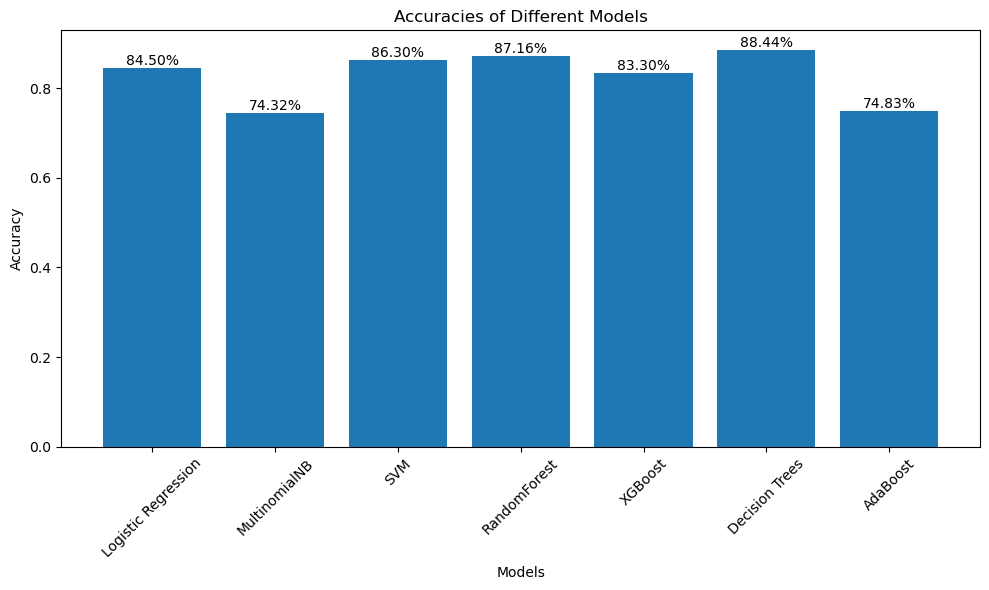

In [78]:
model_names = ['Logistic Regression', 'MultinomialNB', 'SVM', 'RandomForest', 'XGBoost', 'Decision Trees', 'AdaBoost']
accuracies = [accuracy_logreg, accuracy_nb, accuracy_svm, accuracy_rf, accuracy_xgb, accuracy_dt, accuracy_ada]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracies of Different Models')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2%}', ha='center', va='bottom')
    
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

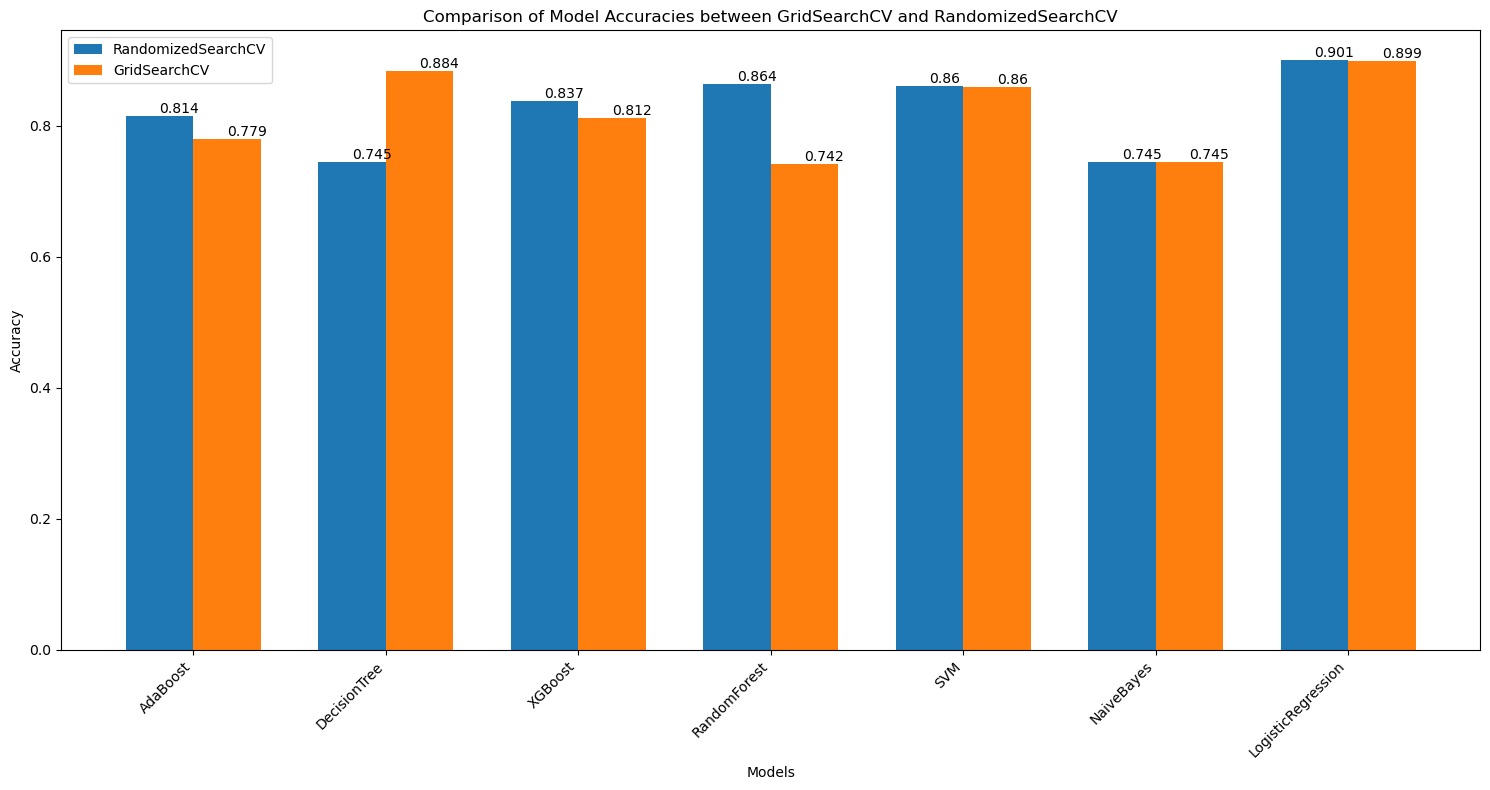

In [98]:
# Model names and accuracies
model_names = ['AdaBoost', 'DecisionTree', 'XGBoost', 'RandomForest', 'SVM', 'NaiveBayes', 'LogisticRegression']
random_search_accuracies = [accuracy_ada_random,accuracy_dt_random,accuracy_xgb_random,accuracy_rf_random,accuracy_svm_random,accuracy_nb_random,accuracy_logreg_random]
grid_search_accuracies = [accuracy_ada_grid,accuracy_dt_grid,accuracy_xgb_grid,accuracy_rf_grid,accuracy_svm_grid,accuracy_nb_grid,accuracy_logreg_grid]

# Plotting the bar plot
plt.figure(figsize=(15, 8))

# Position of bars on x-axis
bar_width = 0.35
index = range(len(model_names))

# Plot bars for RandomizedSearchCV
bars1 = plt.bar(index, random_search_accuracies, bar_width, label='RandomizedSearchCV')

# Plot bars for GridSearchCV
bars2 = plt.bar([i + bar_width for i in index], grid_search_accuracies, bar_width, label='GridSearchCV')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies between GridSearchCV and RandomizedSearchCV')
plt.xticks([i + bar_width/2 for i in index], model_names, rotation=45, ha='right')
plt.legend()

# Annotating accuracy values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom')

# Show plot
plt.tight_layout()
plt.show()

# Deployment Using Streamlit

In [80]:
print(df.columns.tolist())

['Sentence', 'Sentiment', 'Sentiment_label_encode', 'Sentence_length', 'tokenized_text', 'lemmatized_text', 'vader_scores', 'vader_compound', 'vader_sentiment', 'vader_sentiment_label_encode']


In [81]:
import pickle

# Save the best_classifier model
with open('best_classifier_grid.pkl', 'wb') as model_file:
    pickle.dump(best_classifier_random, model_file)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


In [82]:
from IPython.display import FileLink

# Create a link to download the file
FileLink('vectorizer.pkl')


C:\Users\ds_sa\Desktop\Project_P340\vectorizer.pkl

In [83]:
from IPython.display import FileLink

# Create a link to download the file
FileLink('best_classifier_grid.pkl')


C:\Users\ds_sa\Desktop\Project_P340\best_classifier_grid.pkl

In [95]:
import pickle

# Save the tuned Decision Tree model
with open('best_classifier_decision_tree.pkl', 'wb') as model_file:
    pickle.dump(best_classifier_decision_tree, model_file)


In [96]:
from IPython.display import FileLink

# Create a link to download the file
FileLink('best_classifier_decision_tree.pkl')


C:\Users\ds_sa\Desktop\Project_P340\best_classifier_decision_tree.pkl

In [97]:
import streamlit as st
import pandas as pd
import pickle

# Load the trained model
with open('best_classifier_decision_tree.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Streamlit app
def main():
    st.title("Decision Tree Model Deployment")

    # Input text box for user to enter a sentence
    sentence_input = st.text_area("Enter a sentence:")

    if st.button("Predict"):
        # Preprocess the input (you may need to adapt this based on your preprocessing steps)
        # Example assumes X_test_bow is a Bag of Words representation
        input_features = preprocess_input(sentence_input)

        # Make prediction
        prediction = model.predict(input_features)

        # Display the prediction
        st.write("Prediction:", prediction)

if __name__ == "__main__":
    main()
